In [2]:
import os
from os.path import join
import gc
import re
from tqdm import tqdm
import pandas as pd
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util
from plotter import TrackingDataPlotter
from field_control import field_control

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
# Define the path to the data folder
DATA_DIR = "../data/"
WEEKS = range(2,3)

df_game = pd.read_csv(join(DATA_DIR, "games.csv"))
df_play = pd.read_csv(join(DATA_DIR, "plays.csv"))
df_player_play = pd.read_csv(join(DATA_DIR, "player_play.csv"))
df_player = pd.read_csv(join(DATA_DIR, "players.csv"))

tracking_dfs = []
for wk in tqdm(WEEKS, desc="Loading tracking files"):
    df = pd.read_csv(join(DATA_DIR, f'tracking_week_{wk}.csv'))
    if 'week' not in df.columns:
        df.insert(3,'week',wk)
    tracking_dfs.append(df)
    
df_tracking = pd.concat(tracking_dfs, axis=0)

game_id = 2022091901
play_id = 64
df_tracking = df_tracking[(df_tracking.gameId == game_id) & (df_tracking.playId == play_id)].reset_index(drop=True)

del tracking_dfs

Loading tracking files: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


In [4]:
util.uncamelcase_columns(df_game)
util.uncamelcase_columns(df_player)
util.uncamelcase_columns(df_play)
util.uncamelcase_columns(df_player_play)
util.uncamelcase_columns(df_tracking)

# standardize direction to be offense moving right
df_tracking, df_play = util.standardize_direction(df_tracking, df_play)

In [5]:
df_tracking.head()

,game_id,play_id,nfl_id,week,display_name,frame_id,frame_type,time,jersey_number,club,play_direction,x,y,s,a,dis,o,dir,event
0,2022091901,64,37078.0,2,Patrick Peterson,1,BEFORE_SNAP,2022-09-20 00:32:03.3,7.0,MIN,right,33.45,20.17,1.59,0.52,0.16,86.81,284.09,huddle_break_offense
1,2022091901,64,37078.0,2,Patrick Peterson,2,BEFORE_SNAP,2022-09-20 00:32:03.4,7.0,MIN,right,33.49,20.02,1.58,0.42,0.16,88.66,283.80,NaN
2,2022091901,64,37078.0,2,Patrick Peterson,3,BEFORE_SNAP,2022-09-20 00:32:03.5,7.0,MIN,right,33.53,19.86,1.58,0.28,0.16,92.80,285.50,NaN
3,2022091901,64,37078.0,2,Patrick Peterson,4,BEFORE_SNAP,2022-09-20 00:32:03.6,7.0,MIN,right,33.58,19.71,1.59,0.26,0.16,96.23,286.33,NaN
4,2022091901,64,37078.0,2,Patrick Peterson,5,BEFORE_SNAP,2022-09-20 00:32:03.7,7.0,MIN,right,33.62,19.56,1.58,0.34,0.16,98.73,287.92,NaN


In [6]:
df_game.head()

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,home_final_score,visitor_final_score
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [7]:
df_player.head()

,nfl_id,height,weight,birth_date,college_name,position,display_name
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [8]:
df_play.head()

,game_id,play_id,play_description,quarter,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,game_clock,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,absolute_yardline_number,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,expected_points,offense_formation,receiver_alignment,play_clock_at_snap,pass_result,pass_length,target_x,target_y,play_action,dropback_type,dropback_distance,pass_location_type,time_to_throw,time_in_tackle_box,time_to_sack,pass_tipped_at_line,unblocked_pressure,qb_spike,qb_kneel,qb_sneak,rush_location_type,penalty_yards,pre_penalty_yards_gained,yards_gained,home_team_win_probability_added,visitor_team_win_probility_added,expected_points_added,is_dropback,pff_run_concept_primary,pff_run_concept_secondary,pff_run_pass_option,pff_pass_coverage,pff_man_zone,play_direction
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,01:54,35,17,N,31,0.982017,0.017983,0.719313,EMPTY,3x2,10.0,C,6.0,36.69,16.51,False,TRADITIONAL,2.40,INSIDE_BOX,2.990,2.990,NaN,False,False,False,0,NaN,NaN,NaN,9,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,NaN
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,02:13,17,17,N,18,0.424356,0.575644,0.607746,EMPTY,3x2,9.0,C,4.0,20.83,20.49,False,TRADITIONAL,1.14,INSIDE_BOX,1.836,1.836,NaN,False,False,False,0,NaN,NaN,NaN,4,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone,NaN
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,02:00,3,17,N,30,0.006291,0.993709,-0.291485,SHOTGUN,2x2,12.0,C,-4.0,26.02,17.56,False,TRADITIONAL,3.20,INSIDE_BOX,2.236,2.236,NaN,False,False,False,0,NaN,NaN,NaN,6,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone,NaN
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,09:28,0,0,N,33,0.884223,0.115777,4.249382,SHOTGUN,2x2,11.0,C,-6.0,38.95,14.19,False,TRADITIONAL,3.02,INSIDE_BOX,2.202,2.202,NaN,False,False,False,0,NaN,NaN,NaN,4,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone,NaN
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,02:16,10,10,N,37,0.410371,0.589629,3.928413,PISTOL,3x1,8.0,NaN,NaN,NaN,NaN,True,DESIGNED_RUN,2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,INSIDE_LEFT,NaN,-1,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man,NaN


In [9]:
df_player_play.head()

,game_id,play_id,nfl_id,team_abbr,had_rush_attempt,rushing_yards,had_dropback,passing_yards,sack_yards_as_offense,had_pass_reception,receiving_yards,was_targetted_receiver,yardage_gained_after_the_catch,fumbles,fumble_lost,fumble_out_of_bounds,assisted_tackle,forced_fumble_as_defense,half_sack_yards_as_defense,pass_defensed,quarterback_hit,sack_yards_as_defense,safety_as_defense,solo_tackle,tackle_assist,tackle_for_a_loss,tackle_for_a_loss_yardage,had_interception,interception_yards,fumble_recoveries,fumble_recovery_yards,penalty_yards,penalty_names,was_initial_pass_rusher,caused_pressure,time_to_pressure_as_pass_rusher,get_off_time_as_pass_rusher,in_motion_at_ball_snap,shift_since_lineset,motion_since_lineset,was_running_route,route_ran,blocked_player_n_f_l_id1,blocked_player_n_f_l_id2,blocked_player_n_f_l_id3,pressure_allowed_as_blocker,time_to_pressure_allowed_as_blocker,pff_defensive_coverage_assignment,pff_primary_defensive_coverage_matchup_nfl_id,pff_secondary_defensive_coverage_matchup_nfl_id
0,2022090800,56,35472,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,True,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_tracking.head()

,game_id,play_id,nfl_id,week,display_name,frame_id,frame_type,time,jersey_number,club,play_direction,x,y,s,a,dis,o,dir,event
0,2022091901,64,37078.0,2,Patrick Peterson,1,BEFORE_SNAP,2022-09-20 00:32:03.3,7.0,MIN,right,33.45,20.17,1.59,0.52,0.16,86.81,284.09,huddle_break_offense
1,2022091901,64,37078.0,2,Patrick Peterson,2,BEFORE_SNAP,2022-09-20 00:32:03.4,7.0,MIN,right,33.49,20.02,1.58,0.42,0.16,88.66,283.80,NaN
2,2022091901,64,37078.0,2,Patrick Peterson,3,BEFORE_SNAP,2022-09-20 00:32:03.5,7.0,MIN,right,33.53,19.86,1.58,0.28,0.16,92.80,285.50,NaN
3,2022091901,64,37078.0,2,Patrick Peterson,4,BEFORE_SNAP,2022-09-20 00:32:03.6,7.0,MIN,right,33.58,19.71,1.59,0.26,0.16,96.23,286.33,NaN
4,2022091901,64,37078.0,2,Patrick Peterson,5,BEFORE_SNAP,2022-09-20 00:32:03.7,7.0,MIN,right,33.62,19.56,1.58,0.34,0.16,98.73,287.92,NaN


In [11]:
df_tracking.head()

,game_id,play_id,nfl_id,week,display_name,frame_id,frame_type,time,jersey_number,club,play_direction,x,y,s,a,dis,o,dir,event
0,2022091901,64,37078.0,2,Patrick Peterson,1,BEFORE_SNAP,2022-09-20 00:32:03.3,7.0,MIN,right,33.45,20.17,1.59,0.52,0.16,86.81,284.09,huddle_break_offense
1,2022091901,64,37078.0,2,Patrick Peterson,2,BEFORE_SNAP,2022-09-20 00:32:03.4,7.0,MIN,right,33.49,20.02,1.58,0.42,0.16,88.66,283.80,NaN
2,2022091901,64,37078.0,2,Patrick Peterson,3,BEFORE_SNAP,2022-09-20 00:32:03.5,7.0,MIN,right,33.53,19.86,1.58,0.28,0.16,92.80,285.50,NaN
3,2022091901,64,37078.0,2,Patrick Peterson,4,BEFORE_SNAP,2022-09-20 00:32:03.6,7.0,MIN,right,33.58,19.71,1.59,0.26,0.16,96.23,286.33,NaN
4,2022091901,64,37078.0,2,Patrick Peterson,5,BEFORE_SNAP,2022-09-20 00:32:03.7,7.0,MIN,right,33.62,19.56,1.58,0.34,0.16,98.73,287.92,NaN


In [12]:
df_play[(df_play.game_id==game_id) & (df_play.play_id==play_id)].play_description.values[0]

'(14:57) (Shotgun) J.Hurts pass short left to D.Smith to PHI 23 for 5 yards (H.Smith).'

In [ ]:
#TODO orient other direction
#TODO create a dynamic ploting algo frame by frame to not have to plot whole field

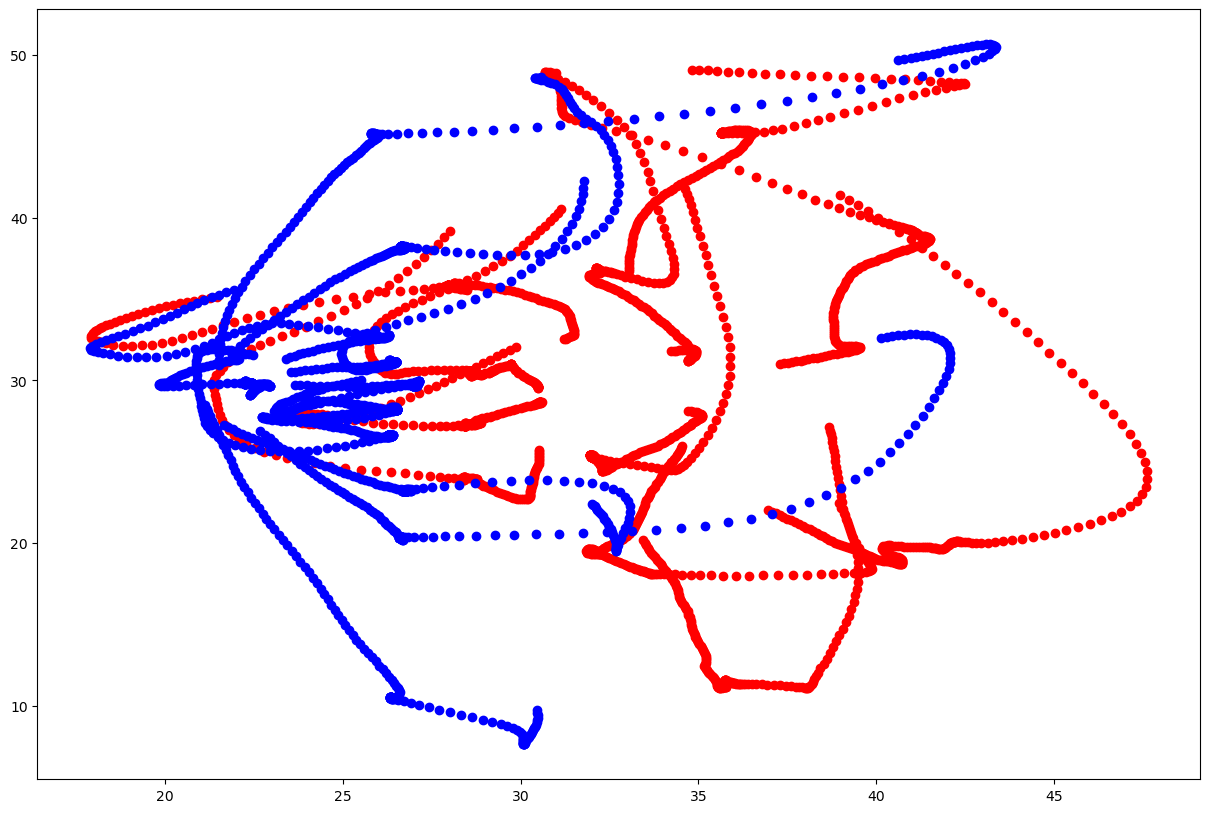

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_play(df_play):
    display_height = 45
    feild_width = 53.3  

    hash_width = 2/3 # 2 feet wide
    inner_left_hash_x = (53.3 / 2) - ((18.5 / 3) / 2)
    inner_right_hash_x = (53.3 / 2) + ((18.5 / 3) / 2)
    outer_left_hash_x = 1 + (hash_width / 2)
    outer_right_hash_x = feild_width - (hash_width / 2)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    clubs = df_play.club.unique().tolist()
    colors = ['red', 'blue']
    for club, color in zip(clubs, colors):
        qry = df_play[df_play.club == club]
        ax.scatter(qry.x, qry.y, color=color)


game_id = 2022091901
play_id = 64
plot_play(df_tracking)